In [1]:
%matplotlib inline
import jplus
import os
import pickle
import elgtools as elg
import numpy as np
import matplotlib.pyplot as plt
import Read_Mocks as read
import MockJPLUS as mtools
import matplotlib.gridspec as gsc
import gc   # To free memory more effectively

Mockpath = '/home/CEFCA/aaorsi/work/JPLUS_Mock/'
namelc   = 'LightCone_SA_0_'

plt.rcParams['figure.figsize'] = 25, 25


In [2]:
import pymangle
generate_random_mask = False

if generate_random_mask:
    jpm_file = '/home/CEFCA/aaorsi/work/jplus_masks/jplus_dr1_mask.pol'
    jplus_mask = pymangle.mangle.Mangle(jpm_file)
    jpran = jplus_mask.genrand(100000)
    ran_mask = {'coords':np.transpose([jpran[0], jpran[1]])}





In [3]:
# Loading SDSS data first

Load_coords = True
Load_ri     = True
Load_ugz    = True
Load_ri_err = True

if Load_coords:
    gal_sdss_coords  = jplus.datasets.fetch_custom_sdss(mag_type="none",overwrite=False,mag_limit=[16,21], extinction=False,
                                                          clean = True, nchunks = 10, spectroscopic=False, 
                                                    casjobs=True, object_name="photgalaxies",get_r=False, get_i=False,
                                                    runname='coords', get_coords=True) 
    id_obj = np.argsort(gal_sdss_coords['object_id'])
    gal_sdss_coords['object_id'] = gal_sdss_coords['object_id'][id_obj]
    gal_sdss_coords['coords'] = gal_sdss_coords['coords'][id_obj,:]
    print 'SDSS coordinates loaded'
    
if Load_ri:
    gal_sdss_r_i  = jplus.datasets.fetch_custom_sdss(mag_type="aperMags",overwrite=False,mag_limit=[16,21], extinction=False,
                                                          clean = True, nchunks = 10, spectroscopic=False, 
                                                    casjobs=True, object_name="photgalaxies",get_r=True, get_i=True,
                                                    runname='r_i', get_coords=False)  
    id_obj = np.argsort(gal_sdss_r_i['object_id'])
    gal_sdss_r_i['object_id'] = gal_sdss_r_i['object_id'][id_obj]
    gal_sdss_r_i['rSDSS'] = gal_sdss_r_i['rSDSS'][id_obj,:]
    gal_sdss_r_i['iSDSS'] = gal_sdss_r_i['iSDSS'][id_obj,:]
    
    print 'SDSS ri loaded'

if Load_ugz:
    gal_sdss_ugz  = jplus.datasets.fetch_custom_sdss(mag_type="aperMags",overwrite=False,mag_limit=[16,21], extinction=False,
                                                          clean = True, nchunks = 10, spectroscopic=False, 
                                                    casjobs=True, object_name="photgalaxies",get_u=True, get_g=True,get_z=True,
                                                    runname='ugz', get_coords=False)    
    print 'SDSS ugz loaded'

    id_obj = np.argsort(gal_sdss_ugz['object_id'])
    gal_sdss_ugz['object_id'] = gal_sdss_ugz['object_id'][id_obj]
    gal_sdss_ugz['uSDSS'] = gal_sdss_ugz['uSDSS'][id_obj,:]
    gal_sdss_ugz['gSDSS'] = gal_sdss_ugz['gSDSS'][id_obj,:]
    gal_sdss_ugz['zSDSS'] = gal_sdss_ugz['zSDSS'][id_obj,:]

if Load_ri_err:    
    gal_sdss_r_i_err = jplus.datasets.fetch_custom_sdss(mag_type="aperMags",overwrite=False,mag_limit=[16,21], extinction=False,
                                                          clean = True, nchunks = 10, spectroscopic=False, 
                                                    casjobs=True, object_name="photgalaxies",get_r_err=True, get_i_err=True,
                                                    runname='r_i_err', get_coords=False)
    print 'SDSS ri errors loaded'

    id_obj = np.argsort(gal_sdss_r_i_err['object_id'])
    gal_sdss_r_i_err['object_id'] = gal_sdss_r_i_err['object_id'][id_obj]
    gal_sdss_r_i_err['rSDSS'] = gal_sdss_r_i_err['rSDSS'][id_obj,:]
    gal_sdss_r_i_err['iSDSS'] = gal_sdss_r_i_err['iSDSS'][id_obj,:]
    
    
    
#gal_sdss_r_i_err = jplus.datasets.fetch_custom_sdss(mag_type="aperMags",overwrite=False,mag_limit=[16,21], extinction=False,
#                                                          clean = True, nchunks = 10, spectroscopic=False, 
#                                                    casjobs=True, object_name="photgalaxies",get_r_err=True, get_i_err=True,
#                                                    runname='r_i_err', get_coords=False)    


j-plus [INFO]: Fetching SDSS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/coords_sdss_photgalaxies_none_magmax21.0.h5
j-plus [INFO]: Fetching SDSS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/r_i_sdss_photgalaxies_aperMags_magmax21.0.h5


SDSS coordinates loaded


j-plus [INFO]: Fetching SDSS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/ugz_sdss_photgalaxies_aperMags_magmax21.0.h5


SDSS ri loaded
SDSS ugz loaded


j-plus [INFO]: Fetching SDSS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/r_i_err_sdss_photgalaxies_aperMags_magmax21.0.h5


SDSS ri errors loaded


In [4]:
# Load J-PLUS catalogue
LoadJPLUSCat = False # if True loads a ELG catalogue of JPLUS already built
mag_type = 'gpsfMags' # or wpsfMags


if LoadJPLUSCat:
    gal_elgs = pickle.load(open(fout))
else:
    gal_jplus0 = jplus.datasets.fetch_jplus_objects(mag_type=mag_type, overwrite=False, 
                                                 object_name="jplus_pz", nchunks=20, mag_limit=[16,24.],
                                                extra_where_conds='',db='dr1', allphotoz=True, upperlimparams=True)



j-plus [INFO]: Fetching J-PLUS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/jplus_jplus_pz_gpsfMags_dr1_dual_magmax24.0.h5


In [ ]:
GetTileMasks = False

if GetTileMasks:
    gal_jplus0['tile_id']

    tilefile = '/home/CEFCA/aaorsi/work/jplus_masks/download_masks.txt'

    f = open(tilefile,'w')
    alltiles = np.unique(gal_jplus0['tile_id'])
    nt = len(alltiles)
    print 'FYI there are %ld tiles in this J-PLUS dataset' % nt

    for i in range(nt):
        f.write('http://upad.cefca.es/catalogues/vo/siap/jplus-dr1-cand/get_masks?id=%d\n' % alltiles[i])

    f.close()



In [5]:
# Further selection cuts of ELGs:

fnames = jplus.datasets.jplus_filter_names()

snr_limit = 3 # Minimum SNR for r, i and J0660


mc = ((gal_jplus0['mask_flags_rJAVA'] == 0) &
     (gal_jplus0['mask_flags_J0660'] == 0) &
     (gal_jplus0['single_detect_J0660'] != 0) &
     (1./gal_jplus0['J0660'][:,1] > snr_limit)) 
    

jp0 = jplus.tools.select_object(gal_jplus0, mc)
    
        
print 'Original ELG selection contains %ld candidates' % len(gal_jplus0['tile_id'])
print 'After removing non-single detections and masked objects, %ld' % len(jp0['tile_id'])
frac = (len(jp0['tile_id']) + 0.0)/(len(gal_jplus0['tile_id'])+0.0)
print 'that is a fraction %f ' % frac

del gal_jplus0
gc.collect()
          

Original ELG selection contains 2980487 candidates
After removing non-single detections and masked objects, 2107441
that is a fraction 0.707079 


124

Cross-match of SDSS phot with J-PLUS ...
Cross-match in 2107441 galaxies,
SDSS: 38167240
nJPLUS: 2107441
xmatch catalogue contains 1155554 galaxies


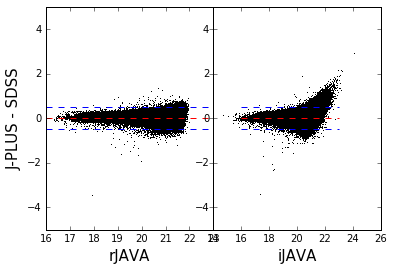

fraction of outliers in rJAVA - rSDSS: 0.002296
fraction of outliers in iJAVA - iSDSS: 0.011388


304

In [6]:
# Cross-match with SDSS


elgdir   = os.getcwd()
fout = '%s/out/elgs.dat' % elgdir
z_oii = [0.73, 0.79]

UseSDSSPhot = True # Use SDSS BB photometry instead of J-PLUS?
AddedPlots = False
AddedPlots2 = True

if AddedPlots or AddedPlots2:
    plt.figure('PlotSDSSPhotometry')
    
    gs = gsc.GridSpec(1,2)
    gs.update(wspace=0.0, hspace=0.0)

    ijlim = -10
    rjlim = -10
    
    if UseSDSSPhot:
        
           
              
       
        
        print 'Cross-match of SDSS phot with J-PLUS ...'
        d,ind = jplus.tools.crossmatch_angular(jp0['coords'],gal_sdss_coords['coords'],max_distance=3e-4)
        m = ((d != np.inf))
        print 'Cross-match in %ld galaxies,\nSDSS: %ld\nnJPLUS: %ld' % (len(m), len(gal_sdss_coords['coords']), 
                                                                        len(jp0['coords']))
        
        jgal = jplus.tools.select_object(jp0, m)

        
        print 'xmatch catalogue contains %ld galaxies' % len(jgal['tile_id'])
        #jplus['in_sdss'] = m
        # Adding SDSS magnitudes
        jgal['rSDSS'] = gal_sdss_r_i['rSDSS'][ind[m]]
        jgal['iSDSS'] = gal_sdss_r_i['iSDSS'][ind[m]]
        jgal['uSDSS'] = gal_sdss_ugz['uSDSS'][ind[m]]
        jgal['gSDSS'] = gal_sdss_ugz['gSDSS'][ind[m]]
        jgal['zSDSS'] = gal_sdss_ugz['zSDSS'][ind[m]]
        
        jgal['rSDSS'][:,1] = gal_sdss_r_i_err['rSDSS'][ind[m],1]
        jgal['iSDSS'][:,1] = gal_sdss_r_i_err['iSDSS'][ind[m],1]
        
        # and their errors ...
#        jgal['rSDSS'][:,1] = gal_sdss_r_i_err['rSDSS'][:,1][ind[m]]
#        jgal['iSDSS'][:,1] = gal_sdss_r_i_err['iSDSS'][:,1][ind[m]]
        
        # Now removing those datasets to save memory
       
        
        nxmatch = len(jgal['rSDSS'][:,0])
        if AddedPlots2:
        
            delta_r = jgal['rJAVA'][:,0] - jgal['rSDSS'][:,0]
            delta_i = jgal['iJAVA'][:,0] - jgal['iSDSS'][:,0]
            
            outliers_r = np.where(np.fabs(delta_r) > .5)[0]
            outliers_i = np.where(np.fabs(delta_i) > .5)[0]
            
            plt.figure('SDSSvsJ-PLUS')
            ax = plt.subplot(gs[0,0])
            ax.plot(jgal['rJAVA'][:,0],delta_r ,',',color='black')
            ax.plot([16,23],[0,0],'--',color='red')
            ax.plot([16,23],[.5,.5],'--',color='blue')
            ax.plot([16,23],[-.5,-.5],'--',color='blue')
            ax.set_ylim([-5,5])
            ax.set_xlabel('rJAVA',fontsize=15)
            ax.set_ylabel('J-PLUS - SDSS',fontsize=15)
            ax = plt.subplot(gs[0,1])
            ax.plot(jgal['iJAVA'][:,0], delta_i, ',',color='black')
            ax.plot([16,23],[0,0],'--',color='red')
            ax.plot([16,23],[.5,.5],'--',color='blue')
            ax.plot([16,23],[-.5,-.5],'--',color='blue')
            ax.set_ylim([-5,5])
            ax.set_xlabel('iJAVA',fontsize=15)
            plt.show()
            
            print 'fraction of outliers in rJAVA - rSDSS: %f' % (len(outliers_r)/(0. + nxmatch))
            print 'fraction of outliers in iJAVA - iSDSS: %f' % (len(outliers_i)/(0. + nxmatch))
        ix = 0
        iy = 0



# Remove SDSS datasets to free memory:
del gal_sdss_r_i
del gal_sdss_r_i_err
del gal_sdss_ugz
del gal_sdss_coords
gc.collect()


In [7]:
# Cross-match with SDSS SpecObj
#%pdb

gal_sdss_spec = jplus.datasets.fetch_sdss_objects(mag_type="aperMags",overwrite=False,mag_limit=[16,21], extinction=False,
                                                          clean = True, nchunks = 5, spectroscopic=True, 
                                                    casjobs=True, object_name="galaxies")


stars_sdss_spec = jplus.datasets.fetch_sdss_objects(mag_type="aperMags",overwrite=False,mag_limit=[16,21], extinction=False,
                                                          clean = True, nchunks = 5, spectroscopic=True, 
                                                    casjobs=True, object_name="stars")

qso_sdss_spec = jplus.datasets.fetch_sdss_objects(mag_type="aperMags",overwrite=False,mag_limit=[16,21], extinction=False,
                                                          clean = True, nchunks = 5, spectroscopic=True, 
                                                    casjobs=True, object_name="qso")


print 'Cross-match of SDSS phot with J-PLUS ...'
d,ind = jplus.tools.crossmatch_angular(jp0['coords'],gal_sdss_spec['coords'],max_distance=3e-4)
m = ((d != np.inf))
print 'Cross-match in %ld galaxies,\nSDSS: %ld\nnJPLUS: %ld' % (len(m), len(gal_sdss_spec['coords']), 
                                                                        len(jp0['coords']))
j_spec = jplus.tools.select_object(jp0, m)

        
print 'xmatch catalogue contains %ld galaxies' % len(j_spec['tile_id'])
        #jplus['in_sdss'] = m
        # Adding SDSS magnitudes
j_spec['rSDSS'] = gal_sdss_spec['rSDSS'][ind[m]]
j_spec['iSDSS'] = gal_sdss_spec['iSDSS'][ind[m]]
j_spec['uSDSS'] = gal_sdss_spec['uSDSS'][ind[m]]
j_spec['gSDSS'] = gal_sdss_spec['gSDSS'][ind[m]]
j_spec['zSDSS'] = gal_sdss_spec['zSDSS'][ind[m]]
j_spec['zspec'] = gal_sdss_spec['zspec'][ind[m]]

        #jgal['rSDSS'][:,1] = gal_sdss_r_i_err['rSDSS'][ind[m],1]
        #jgal['iSDSS'][:,1] = gal_sdss_r_i_err['iSDSS'][ind[m],1]
        

# Xmatch of Spec-stars now:
d,ind = jplus.tools.crossmatch_angular(jp0['coords'],stars_sdss_spec['coords'],max_distance=3e-4)
m = ((d != np.inf))
print 'Cross-match in %ld galaxies,\nSDSS: %ld\nnJPLUS: %ld' % (len(m), len(stars_sdss_spec['coords']), 
                                                                        len(jp0['coords']))
j_star = jplus.tools.select_object(jp0, m)
j_star['rSDSS'] = stars_sdss_spec['rSDSS'][ind[m]]
j_star['iSDSS'] = stars_sdss_spec['iSDSS'][ind[m]]
j_star['uSDSS'] = stars_sdss_spec['uSDSS'][ind[m]]
j_star['gSDSS'] = stars_sdss_spec['gSDSS'][ind[m]]
j_star['zSDSS'] = stars_sdss_spec['zSDSS'][ind[m]]
j_star['zspec'] = stars_sdss_spec['zspec'][ind[m]]


# Xmatch of Spec-QSOs now:
d,ind = jplus.tools.crossmatch_angular(jp0['coords'],qso_sdss_spec['coords'],max_distance=3e-4)
m = ((d != np.inf))
print 'Cross-match in %ld galaxies,\nSDSS: %ld\nnJPLUS: %ld' % (len(m), len(qso_sdss_spec['coords']),
                                                                        len(jp0['coords']))
j_qso = jplus.tools.select_object(jp0, m)
j_qso['rSDSS'] = qso_sdss_spec['rSDSS'][ind[m]]
j_qso['iSDSS'] = qso_sdss_spec['iSDSS'][ind[m]]
j_qso['uSDSS'] = qso_sdss_spec['uSDSS'][ind[m]]
j_qso['gSDSS'] = qso_sdss_spec['gSDSS'][ind[m]]
j_qso['zSDSS'] = qso_sdss_spec['zSDSS'][ind[m]]
j_qso['zspec'] = qso_sdss_spec['zspec'][ind[m]]

# removing spec data to free memory

del stars_sdss_spec
del gal_sdss_spec
del qso_sdss_spec
gc.collect()

    


j-plus [INFO]: Fetching SDSS objects
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/sdss_galaxies_aperMags_magmax21.0.h5
j-plus [INFO]: Fetching SDSS objects
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/sdss_stars_aperMags_magmax21.0.h5
j-plus [INFO]: Fetching SDSS objects
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/sdss_qso_aperMags_magmax21.0.h5


Cross-match of SDSS phot with J-PLUS ...
Cross-match in 2107441 galaxies,
SDSS: 2087487
nJPLUS: 2107441
xmatch catalogue contains 75477 galaxies
Cross-match in 2107441 galaxies,
SDSS: 640948
nJPLUS: 2107441
Cross-match in 2107441 galaxies,
SDSS: 385530
nJPLUS: 2107441


0

In [8]:
clean_xmatch = (np.fabs(delta_r) < 2) & (np.fabs(delta_i) < 2) & (jgal['rSDSS'][:,0] < 22) & (jgal['rSDSS'][:,0] > 16) 
jplus_clean = jplus.tools.select_object(jgal, clean_xmatch)

print 'Number of clean xmatches: %ld\nOriginal catalogue has %ld' % (len(jplus_clean['tile_id']), len(jgal['tile_id']))



Number of clean xmatches: 1155113
Original catalogue has 1155554


In [ ]:
plt.figure('Errors')

plt.plot(jgal['rJAVA'][:,0], jgal['rSDSS'][:,1] - jgal['rJAVA'][:,1], 'k,')
plt.xlabel('rJAVA',fontsize=20)
plt.ylabel('rSDSS_err - rJAVA_err',fontsize=20)

plt.xlim([16,22])
plt.ylim([-.1,.1])
plt.plot([0,30],[0,0],linewidth=5,color='yellow')

plt.show()





In [9]:
# Loading Lightcone galaxies
nCone = 512
lcone = []

Mockpath = '/home/CEFCA/aaorsi/work/JPLUS_Mock/new/Lines/'
namelc   = 'LightCone_SA_0_'

print 'reading Lightcone...'
for i in range(nCone): #nCone):
    nameIn = '%s%s%d' % (Mockpath, namelc, i)
    ilc = read.readmock_chunk_PythonCut(nameIn, zspace = True)
    lcone.append(ilc[0])
    
dcone = np.concatenate(lcone)


reading Lightcone...


In [10]:
# Loading Convolved spectra

import learn_elgs as learn
tfout = '/home/CEFCA/aaorsi/work/elg_jplus/trainspec.dat'
allspec, photo_spec = learn.LoadSample(tfout,overwrite=False, sdssxjplus=False)



j-plus [INFO]:    Downloading eBOSS ELG composite spectrum from https://data.sdss.org/sas/dr13/eboss/elg/composite/v1_0/eBOSS_ELG_composite.fits


[========================================]  92.8kb / 92.8kb   


j-plus [INFO]: Fetching  J-PLUS filters


[-0.0072231255252628059, 0.020158269506669296]
[0.30129710948226485, 0.33718768179993419]
[0.34038153202585891, 0.37735007668633419]
[0.74821428150729818, 0.79643110350745117]


In [ ]:

ns = len(allspec)
sname = [allspec[i]['survey'] for i in range(ns)]
surveys = np.unique(sname)
print surveys

nspec = []

for si in range(len(surveys)):
    sel = (sname == surveys[si])
    print sel

print nspec

In [11]:


print dcone.dtype

f_j0660 = jplus.datasets.fetch_jplus_filter('J0660') # Filter transmission curve

w_oii = 3727.0 # OII rest-frame
z_oii = elg.zline(w_oii, f_j0660.wave, f_j0660.throughput)

w_ha = 6563.0
z_ha = elg.zline(w_ha, f_j0660.wave, f_j0660.throughput)

w_hb = 4861.0
z_hb = elg.zline(w_hb, f_j0660.wave, f_j0660.throughput)

w_oiii = 5007.0
z_oiii = elg.zline(w_oiii, f_j0660.wave, f_j0660.throughput)


print z_oii



j-plus [INFO]: Fetching  J-PLUS filters


[('Type', '<i4'), ('Mvir', '<f4'), ('pos', '<f4', (3,)), ('vel', '<f4', (3,)), ('sfr', '<f4'), ('sfr_inst', '<f4'), ('BulgeMass', '<f4'), ('DiskMass', '<f4'), ('Time', '<f4'), ('redshift', '<f4'), ('BlackholeMass', '<f4'), ('MetalColdGas', '<f4'), ('ColdGas', '<f4'), ('MassWeightAge', '<f4'), ('ObsMagDust', '<f4', (12,))]
[0.7482142815072982, 0.7964311035074512]


Computing 3FM on mocks and J-PLUS ...
done
21.99986
16.40005
[ 16.36734694  16.48979592  16.6122449   16.73469388  16.85714286
  16.97959184  17.10204082  17.2244898   17.34693878  17.46938776
  17.59183673  17.71428571  17.83673469  17.95918367  18.08163265
  18.20408163  18.32653061  18.44897959  18.57142857  18.69387755
  18.81632653  18.93877551  19.06122449  19.18367347  19.30612245
  19.42857143  19.55102041  19.67346939  19.79591837  19.91836735
  20.04081633  20.16326531  20.28571429  20.40816327  20.53061224
  20.65306122  20.7755102   20.89795918  21.02040816  21.14285714
  21.26530612  21.3877551   21.51020408  21.63265306  21.75510204
  21.87755102  22.        ]
NELGs  1425
dm from doDM [ 0.11293695 -0.14352375 -0.13638593 ...,  0.56789859  0.20771236
  0.11403176]
[-0.05791059  0.0039303   0.04555721  0.0715503   0.03953249  0.06829719
  0.06287987  0.06327861  0.0712052   0.07204798  0.07196447  0.07747175
  0.08615787  0.09580556  0.10048202  0.10118298  0.10541712  0.10

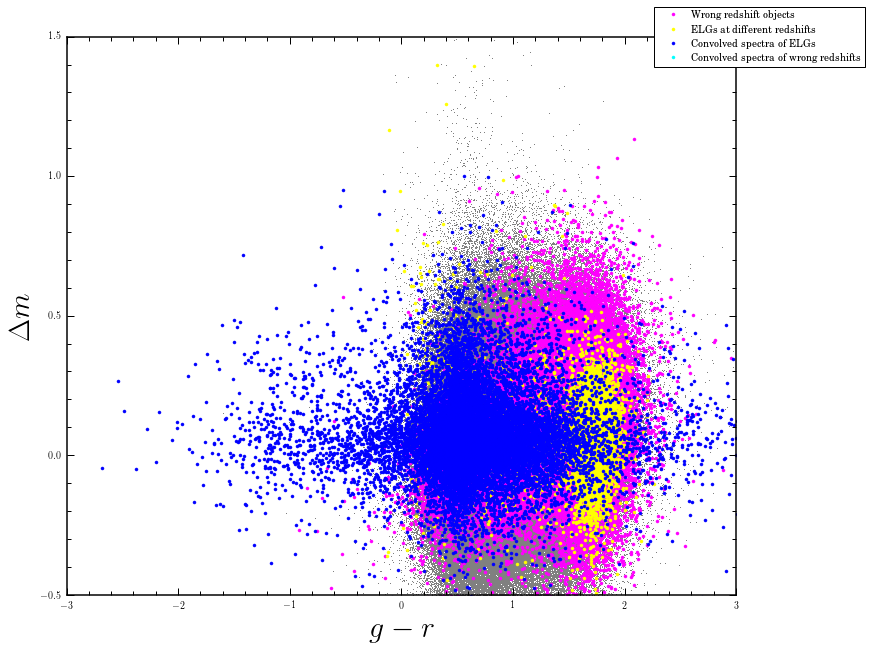

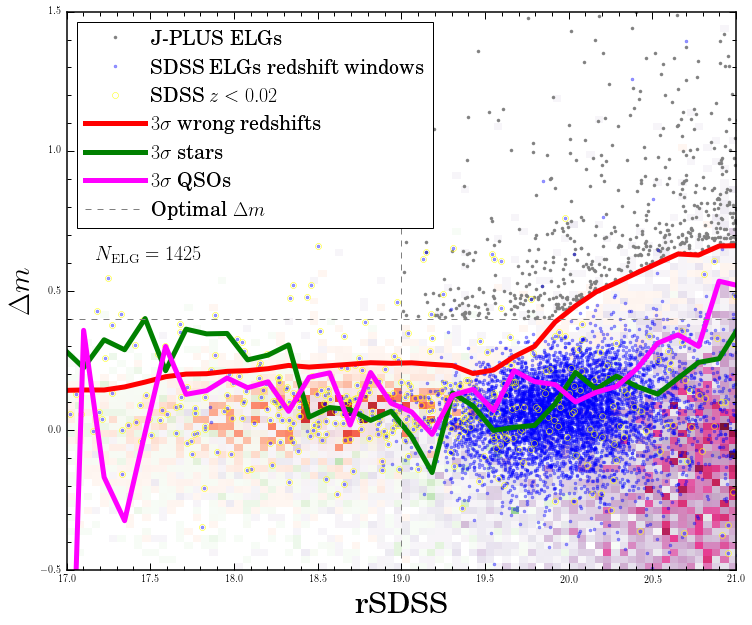

In [14]:

#import pdb
from scipy.interpolate import interp1d

# Shortcuts for magnitudes

r_mock     = mtools.app_mag(dcone, 'rSDSS')
g_mock     = mtools.app_mag(dcone, 'gSDSS')
i_mock     = mtools.app_mag(dcone, 'iSDSS')
z_mock     = mtools.app_mag(dcone, 'zSDSS')
j0660_mock     = mtools.app_mag(dcone, 'J0660')
j0861_mock     = mtools.app_mag(dcone, 'J0861')

g_jplus = jplus_clean['gJAVA'][:,0]
r_jplus = jplus_clean['rSDSS'][:,0]
z_jplus = jplus_clean['zJAVA'][:,0]
i_jplus = jplus_clean['iSDSS'][:,0]
j0660_jplus = jplus_clean['J0660'][:,0]
j0861_jplus = jplus_clean['J0861'][:,0]

j0660_spec = photo_spec['J0660'][:,0]
j0861_spec = photo_spec['J0861'][:,0]
r_spec = photo_spec['rJAVA'][:,0]
i_spec = photo_spec['iJAVA'][:,0]
g_spec = photo_spec['gJAVA'][:,0]  # gJAVA, zJAVA are not fully sampled by VIMOS spectra (VVDS, VIPERS)
z_spec = photo_spec['zJAVA'][:,0]  # gJAVA, zJAVA are not fully sampled by VIMOS spectra (VVDS, VIPERS)

# Computing 3FM on each dataset
print 'Computing 3FM on mocks and J-PLUS ...'

dm_mocks = mtools.tfm(dcone,broad_noline='iSDSS')
dm_jplus = mtools.gen_3fm(jplus_clean['J0660'][:,0], jplus_clean['rSDSS'][:,0], 
                          jplus_clean['iSDSS'][:,0],Broad_NoLineName='iSDSS')

dm_java = mtools.gen_3fm(jplus_clean['J0660'][:,0], jplus_clean['rJAVA'][:,0], 
                          jplus_clean['iJAVA'][:,0],Broad_NoLineName='iSDSS')


dm_spec = mtools.gen_3fm(photo_spec['J0660'][:,0], photo_spec['rJAVA'][:,0], 
                          photo_spec['iJAVA'][:,0],Broad_NoLineName='iSDSS')


dm_jspec = mtools.gen_3fm(j_spec['J0660'][:,0], j_spec['rSDSS'][:,0], 
                          j_spec['iSDSS'][:,0],Broad_NoLineName='iSDSS')


nspec = len(allspec)
zsp = np.zeros(nspec)
for i in range(nspec):
    zsp[i] = allspec[i]['z']
    
photo_spec['z'] = zsp

print 'done'

mock_rlim = 21.3


cond_mocks = (dm_mocks > 0.4) & (r_mock > 20)
cond_jplus = (dm_jplus > 0.4) & (jplus_clean['rSDSS'][:,0] > 20) & (~np.isnan(dm_jplus)) & (jplus_clean['rSDSS'][:,0] < mock_rlim)
cond_spec  = (dm_spec > 0.4) & (r_spec > 20)


ELG_zspec = (((j_spec['zspec'] > z_ha[0])   & (j_spec['zspec'] < z_ha[1])   ) |
             ((j_spec['zspec'] > z_hb[0])   & (j_spec['zspec'] < z_hb[1])   ) |
             ((j_spec['zspec'] > z_oiii[0]) & (j_spec['zspec'] < z_oiii[1]) ) |
             ((j_spec['zspec'] > z_oii[0])  & (j_spec['zspec'] < z_oii[1])  )) 


speccat_ELG = (((photo_spec['z'] > z_ha[0])   & (photo_spec['z'] < z_ha[1])   ) |
               ((photo_spec['z'] > z_hb[0])   & (photo_spec['z'] < z_hb[1])   ) |
               ((photo_spec['z'] > z_oiii[0]) & (photo_spec['z'] < z_oiii[1]) ) |
               ((photo_spec['z'] > z_oii[0])  & (photo_spec['z'] < z_oii[1])  )) 


#mock_ELG = 


j_spec_ELGs = jplus.tools.select_object(j_spec, ELG_zspec)
j_spec_noELGs = jplus.tools.select_object(j_spec, ~ELG_zspec)

dm_jELG = mtools.gen_3fm(j_spec_ELGs['J0660'][:,0], j_spec_ELGs['rSDSS'][:,0], 
                          j_spec_ELGs['iSDSS'][:,0],Broad_NoLineName='iSDSS')

dm_jnoELG = mtools.gen_3fm(j_spec_noELGs['J0660'][:,0], j_spec_noELGs['rSDSS'][:,0], 
                          j_spec_noELGs['iSDSS'][:,0],Broad_NoLineName='iSDSS')                         
                         


#m_ha = cond_mocks & (dcone['redshift'] > z_ha[0]) & (dcone['redshift'] < z_ha[1])
#m_hb = cond_mocks & (dcone['redshift'] > z_hb[0]) & (dcone['redshift'] < z_hb[1])
#m_oii = cond_mocks & (dcone['redshift'] > z_oii[0]) & (dcone['redshift'] < z_oii[1])
#m_oiii = cond_mocks & (dcone['redshift'] > z_oiii[0]) & (dcone['redshift'] < z_oiii[1])


plt.figure(111)
plt.rcParams['font.family'] = 'STIXGeneral'
nbins = 50
r_arr = np.linspace(16,22,nbins)
rbin = r_arr[1] - r_arr[0]
pp = np.zeros(nbins)
pp2 = np.zeros(nbins)


rj = jplus_clean['rSDSS'][:,0]
for i in range(nbins):
    sel = np.where((rj > r_arr[i] - rbin/2. ) & (rj < r_arr[i] + rbin/2.))[0]
    dm_r = dm_jplus[sel]
    
    
    if len(dm_r) > 0:
        pp[i] = np.percentile(dm_jplus[sel],84.)
        pp2[i] = np.percentile(dm_java[sel],84)
    
nzero = pp > 0    
#plt.plot(r_arr[nzero],pp[nzero],color='green',linewidth=5)
#plt.plot(r_arr[nzero],pp2[nzero],color='yellow',linewidth=5)
plt.ylim([-1,1])
plt.xlabel('rSDSS',fontsize=30)
plt.ylabel(r'$\Delta m$',fontsize=30)

pline = interp1d(r_arr[nzero],pp[nzero])

print np.max(jplus_clean['rSDSS'][:,0])
print np.min(jplus_clean['rSDSS'][:,0])
print r_arr[nzero]
jplus_clean['dm'] = dm_jplus 
jplus_clean['dmsigma']  = jplus_clean['dm']/(pline(jplus_clean['rSDSS'][:,0]))
mask = jplus_clean['dmsigma'] > 2.0

#elgs = jplus.tools.select_object(jplus_clean, mask)

#plt.plot(elgs['rSDSS'][:,0],elgs['dm'],'r.')

j_spec_ELGs = jplus.tools.select_object(j_spec, ELG_zspec)
j_spec_noELGs = jplus.tools.select_object(j_spec, ~ELG_zspec)

j_spec_ELGs['dm'] = mtools.gen_3fm(j_spec_ELGs['J0660'][:,0], j_spec_ELGs['rSDSS'][:,0], 
                          j_spec_ELGs['iSDSS'][:,0],Broad_NoLineName='iSDSS')

j_spec_noELGs['dm'] = mtools.gen_3fm(j_spec_noELGs['J0660'][:,0], j_spec_noELGs['rSDSS'][:,0], 
                          j_spec_noELGs['iSDSS'][:,0],Broad_NoLineName='iSDSS')

j_star['dm'] = mtools.gen_3fm(j_star['J0660'][:,0], j_star['rSDSS'][:,0], 
                          j_star['iSDSS'][:,0],Broad_NoLineName='iSDSS')

j_qso['dm'] = mtools.gen_3fm(j_qso['J0660'][:,0], j_qso['rSDSS'][:,0], 
                          j_qso['iSDSS'][:,0],Broad_NoLineName='iSDSS')



lowz = j_spec['zspec'] < z_ha[1]
lowz_jplus = jplus.tools.select_object(j_spec,lowz)

lowz_jplus['dm'] = mtools.gen_3fm(lowz_jplus['J0660'][:,0], lowz_jplus['rSDSS'][:,0], 
                          lowz_jplus['iSDSS'][:,0],Broad_NoLineName='iSDSS')

wz_r = np.zeros(nbins)
wz = j_spec_noELGs['rSDSS'][:,0]
for i in range(nbins):
    sel = np.where((wz > r_arr[i] - rbin/2. ) & (wz < r_arr[i] + rbin/2.))[0]
    dm_wz = j_spec_noELGs['dm'][sel]
    wz_r[i] = np.percentile(dm_wz,84.) if len(dm_wz) > 0 else -1
        

nzero = wz_r > 0         
wzline = interp1d(r_arr, wz_r)        

# Computing 1-sigma line for stars
wz_r_star = np.zeros(nbins)
wz = j_star['rSDSS'][:,0]
for i in range(nbins):
    sel = np.where((wz > r_arr[i] - rbin/2. ) & (wz < r_arr[i] + rbin/2.))[0]
    dm_wz = j_star['dm'][sel]
    wz_r_star[i] = np.percentile(dm_wz,84.) if len(dm_wz) > 0 else -1
        

nzero = wz_r_star > 0         
wzline_star = interp1d(r_arr, wz_r_star)        


# Computing 1-sigma line for qso
wz_r_qso = np.zeros(nbins)
wz = j_qso['rSDSS'][:,0]
for i in range(nbins):
    sel = np.where((wz > r_arr[i] - rbin/2. ) & (wz < r_arr[i] + rbin/2.))[0]
    dm_wz = j_qso['dm'][sel]
    wz_r_qso[i] = np.percentile(dm_wz,84.) if len(dm_wz) > 0 else -1
        

nzero = wz_r_qso > 0         
wzline_qso = interp1d(r_arr, wz_r_qso)        



maxR = 19.0

err_dm_jplus = mtools.gen_3fm_err(jplus_clean['J0660'][:,0], jplus_clean['J0660'][:,1], jplus_clean['rSDSS'][:,0], jplus_clean['rSDSS'][:,1], 
                          jplus_clean['iSDSS'][:,0], jplus_clean['iSDSS'][:,1],Broad_NoLineName='iSDSS')

mask = ((dm_jplus/wzline(jplus_clean['rSDSS'][:,0]) > 2.0) & 
        (dm_jplus > 0.4) &
        (jplus_clean['rSDSS'][:,0] > maxR) &
        (dm_jplus/err_dm_jplus > 2))

elgs = jplus.tools.select_object(jplus_clean, mask)
elgs['dm'] = dm_jplus[mask]
elgs['err_dm'] = err_dm_jplus[mask]



nelg = len(elgs['dm'])
print 'NELGs ',nelg
meanR = np.mean(j_spec_ELGs['rSDSS'][:,0])
mean_specR = np.mean(photo_spec['rJAVA'][:,0])
from matplotlib.colors import LogNorm
corr = meanR - mean_specR

xr = [17,21]
yr = [-.5,1.5]

plt.plot(elgs['rSDSS'][:,0],elgs['dm'],'.', color='gray', label='J-PLUS ELGs')
#c, yb, xb, im = plt.hist2d(jplus_clean['rSDSS'][:,0], dm_jplus, bins=50, range=[xr, yr], cmap=plt.cm.Greys, 
#                          normed=LogNorm(), alpha=0.5)

nonan = (~np.isnan(j_spec_noELGs['dm']))
counts, ybins, xbins, image = plt.hist2d(j_spec_noELGs['rSDSS'][nonan,0], j_spec_noELGs['dm'][nonan], bins=80, 
                                         range=[xr, yr],cmap=plt.cm.Reds, normed=LogNorm(), 
                                         cmin=0.01, label='SDSS wrong redshifts', alpha=0.9)

counts, ybins, xbins, image = plt.hist2d(j_star['rSDSS'][:,0], j_star['dm'], bins=80, 
                                         range=[xr, yr],cmap=plt.cm.Greens, normed=LogNorm(), 
                                         cmin=0.01, label='SDSS stars', alpha=0.9)

counts, ybins, xbins, image = plt.hist2d(j_qso['rSDSS'][:,0], j_qso['dm'], bins=80, 
                                         range=[xr, yr],cmap=plt.cm.PuRd, normed=LogNorm(), 
                                         cmin=0.01, label='SDSS QSOs', alpha=0.9)


#plt.plot(j_spec_noELGs['rSDSS'][nonan,0], j_spec_noELGs['dm'][nonan],'.',color='magenta', label='SDSS wrong redshifts')

print 'dm from doDM', j_spec_noELGs['dm'][nonan]

#counts, ybins, xbins, image = plt.hist2d(j_spec_ELGs['rSDSS'][:,0], j_spec_ELGs['dm'], bins=80, 
#                                         range=[xr, yr],cmap=plt.cm.YlGn, normed=LogNorm(), cmin=0.01, alpha=0.3)
plt.plot(j_spec_ELGs['rSDSS'][:,0], j_spec_ELGs['dm'],'.',color='blue', label='SDSS ELGs redshift windows', alpha=.4)
plt.plot(lowz_jplus['rSDSS'][:,0], lowz_jplus['dm'],'o',color='yellow', label=r'SDSS $z < %.2f$'%z_ha[1], alpha=1, fillstyle='none')
print wzline(r_arr)
plt.plot(r_arr, 2*wzline(r_arr), '-', color='red', linewidth=5, label=r'$3\sigma$ wrong redshifts')
plt.plot(r_arr, 2*wzline_star(r_arr), '-', color='green', linewidth=5, label=r'$3\sigma$ stars')
plt.plot(r_arr, 2*wzline_qso(r_arr), '-', color='magenta', linewidth=5, label=r'$3\sigma$ QSOs')
plt.plot(xr,[0.4,0.4],'--', color='gray',label=r'Optimal $\Delta m$')
plt.plot([maxR,maxR,],yr,'--', color='gray')
plt.text(xr[0]*1.01, yr[1]*.4, r'$N_{\rm ELG}=%d$'%nelg, fontsize=20)
plt.xlim(xr)
plt.ylim(yr)
plt.legend(fontsize=20, loc='upper left')



# ----

plt.figure('dm vs color')
plt.plot(jplus_clean['gSDSS'][:,0] - jplus_clean['rSDSS'][:,0],dm_jplus,',', color='gray')
plt.plot(j_spec_noELGs['gSDSS'][:,0] - j_spec_noELGs['rSDSS'][:,0], j_spec_noELGs['dm'],'.',color='magenta', label='Wrong redshift objects')
plt.plot(j_spec_ELGs['gSDSS'][:,0] - j_spec_ELGs['rSDSS'][:,0], j_spec_ELGs['dm'],'.',color='yellow', label='ELGs at different redshifts')
plt.plot(photo_spec['gJAVA'][speccat_ELG,0]  - photo_spec['rJAVA'][speccat_ELG,0],dm_jspec[speccat_ELG],'.',color='blue',label='Convolved spectra of ELGs')
plt.plot(photo_spec['gJAVA'][~speccat_ELG,0] - photo_spec['rJAVA'][~speccat_ELG,0],dm_jspec[~speccat_ELG],'.',color='cyan',label='Convolved spectra of wrong redshifts')
plt.ylim([-1,1])
plt.xlabel(r'$g - r$',fontsize=30)
plt.ylabel(r'$\Delta m$',fontsize=30)
plt.xlim([-3,3])
plt.ylim([-.5,1.5])
plt.legend(loc='center right', bbox_to_anchor=(1.2, 1.0))





In [15]:
# Save ELG candidates and mask in a file
import pickle

elgfile = 'ELG_cand.data'
nelgs = len(elgs['tile_id'])
print nelgs
with open(elgfile,'wb') as outfile:
    pickle.dump(elgs,outfile,protocol=pickle.HIGHEST_PROTOCOL)

    

1425


In [ ]:
# Cross match between ELG candidates and known QSOs:

d,ind = jplus.tools.crossmatch_angular(elgs['coords'],j_qso['coords'],max_distance=3e-4)
m = ((d != np.inf))
print 'Cross-match between ELG candidates and QSOs: %ld' % len(ind[m])

elg_qso = jplus.tools.select_object(elgs,m)


#j_qso = jplus.tools.select_object(jp0, m)
#j_qso['rSDSS'] = qso_sdss_spec['rSDSS'][ind[m]]




#print allspec[0].keys()
#nspec = len(allspec)
#zsp = np.zeros(nspec)
#for i in range(nspec):
#    zsp[i] = allspec[i]['z']
    
#photo_spec['z'] = zsp
#print photo_spec.keys()

# Trying to get MLZ to run here:
# TODO









In [ ]:
# 3FM for all filters
reload(mtools)
cnames = ['J0378, ug', 'J0515, gr', 'J0660, ri', 'J0861, iz']
cmap = plt.cm.Set3(np.linspace(.1,.9,4))
dm_min = 0.4

dm_J0515 = mtools.gen_3fm(elgs['J0515'][:,0], elgs['gSDSS'][:,0], 
                          elgs['rSDSS'][:,0],Broad_NoLineName='rSDSS', LineFilterName='J0515', Broad_LineName='gSDSS')
err_dm_J0515 = mtools.gen_3fm_err(elgs['J0515'][:,0], elgs['J0515'][:,1], elgs['gSDSS'][:,0], elgs['gSDSS'][:,1], 
                          elgs['rSDSS'][:,0], elgs['rSDSS'][:,1],Broad_NoLineName='rSDSS')


dm_J0378 = mtools.gen_3fm(elgs['J0378'][:,0], elgs['uSDSS'][:,0], 
                          elgs['gSDSS'][:,0],Broad_NoLineName='gSDSS', LineFilterName='J0378', Broad_LineName='uJAVA')
err_dm_J0378 = mtools.gen_3fm_err(elgs['J0378'][:,0], elgs['J0378'][:,1], elgs['uSDSS'][:,0], elgs['uSDSS'][:,1], 
                          elgs['gSDSS'][:,0], elgs['gSDSS'][:,1],Broad_NoLineName='gSDSS')

dm_J0861 = mtools.gen_3fm(elgs['J0861'][:,0], elgs['zSDSS'][:,0], 
                          elgs['iSDSS'][:,0],Broad_NoLineName='iSDSS', LineFilterName='J0861', Broad_LineName='zSDSS')

err_dm_J0861 = mtools.gen_3fm_err(elgs['J0861'][:,0], elgs['J0861'][:,1], elgs['zSDSS'][:,0], elgs['zSDSS'][:,1], 
                          elgs['iSDSS'][:,0], elgs['iSDSS'][:,1],Broad_NoLineName='iSDSS')

dm_J0660     = elgs['dm']
err_dm_J0660 = elgs['err_dm']

dm_st = 1  # minimum deltam / error

noise_dm_J0378 = dm_J0378 / err_dm_J0378 < dm_st
noise_dm_J0515 = dm_J0515 / err_dm_J0515 < dm_st
noise_dm_J0861 = dm_J0861 / err_dm_J0861 < dm_st

#dm_J0378[noise_dm_J0378] = 0
#dm_J0515[noise_dm_J0515] = 0
#dm_J0861[noise_dm_J0861] = 0

plt.figure('dm_hist')
gs2 = gsc.GridSpec(4,4)
gs2.update(wspace=0.0, hspace=0.0)

d_thr = 0.2 # detection threshold

s_ha     = (dm_J0378 > d_thr) & (dm_J0515 > d_thr) & (dm_J0660 > d_thr) & (dm_J0861 < d_thr)
s_hboiii = (dm_J0378 < d_thr) & (dm_J0515 > d_thr) & (dm_J0660 > d_thr) & (dm_J0861 > d_thr)
s_oii    = (dm_J0378 < d_thr) & (dm_J0515 < d_thr) & (dm_J0660 > d_thr) & (dm_J0861 > d_thr)

#z_arr = [zha, zhb, zoiii, zoii]

sel_arr = [s_ha, s_hboiii, s_oii, ~s_ha & ~s_hboiii & ~s_oii]
z_arr   = [z_ha, [np.min([z_hb,z_oiii]), np.max([z_hb, z_oiii])], z_oii, [0,1100]]
str_arr = [r'$H\alpha$', r'$H\beta+[O\textsc{iii}]$',r'$[O\textsc{ii}]$', r'Unknown']
for j in range(len(sel_arr)):
    sj = sel_arr[j]
    mj = [dm_J0378[sj], dm_J0515[sj], dm_J0660[sj], dm_J0861[sj]]
    for i in range(len(mj)):
        ax2 = plt.subplot(gs2[j,i])    
        ax2.hist(mj[i],bins= 30, label=cnames[i], facecolor=cmap[i],normed=True,range=[-.5,2],alpha=0.75, log=True)
        ax2.set_ylim([1e-1,20])
        ax2.set_xlim([-.5, 1.9])
        
        
        if i == 0:
            ax2.text(0.5,0.75, str_arr[j],fontsize=12, transform=ax2.transAxes)
            ax2.text(0.5,0.65, r'$N_{\rm gal}=%d$'%len(mj[i]), fontsize=10, transform=ax2.transAxes)
            ax2.text(0.5,0.55,r'$%.2f<z<%.2f$'% (z_arr[j][0], z_arr[j][1]), fontsize=10, transform=ax2.transAxes)
        
        ax2.legend()
        if i > 0:
            ax2.set_yticklabels([])
        
        ax2.plot([0,0], [1e-3,100],'--')
        if i == 2:
            ax2.plot([dm_min, dm_min], [-1,100],'--',linewidth=3,color='black')
        ax2.set_xlabel(r'$\Delta m$',fontsize=20)
    
    
    
plt.show()






In [ ]:
import astropy.coordinates as coord
import astropy.units as u

plt.rcParams['figure.figsize'] = 30, 30
ljp = len(ran_mask['coords'])
#jpid = np.random.random_integers(0,ljp,int(ljp/2))
jpid = np.arange(0,ljp)

ra = coord.Angle(ran_mask['coords'][jpid,0]*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(ran_mask['coords'][jpid,1]*u.degree)

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
ax.plot(ra.radian, dec.radian,'k.', label='random mask', alpha=0.7)

jpid = np.arange(0,len(elgs['tile_id']))

ra = coord.Angle(elgs['coords'][jpid,0]*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(elgs['coords'][jpid,1]*u.degree)

ax = fig.add_subplot(111, projection='mollweide')
ax.plot(ra.radian, dec.radian,'.', label='J-PLUS ELGs', alpha=0.7,color='royalblue')

ax.legend(fontsize=30)


In [ ]:
    
ranfile = 'random_mask.data'

with open(ranfile,'wb') as outfile:
    pickle.dump(ran_mask,outfile,protocol=pickle.HIGHEST_PROTOCOL)

print 'files saved OK'

In [ ]:
# Get Photo-z from the above samples
#sel_arr = [s_ha, s_hboiii, s_oii, ~s_ha & ~s_hboiii & ~s_oii]

jplus_ha      = jplus.tools.select_object(elgs,s_ha)
jplus_hb_oiii = jplus.tools.select_object(elgs,s_hboiii)
jplus_oii     = jplus.tools.select_object(elgs,s_oii)
jplus_unknown = jplus.tools.select_object(elgs, ~s_ha & ~s_hboiii & ~s_oii)


jplus_sample = [jplus_ha, jplus_hb_oiii, jplus_oii, jplus_unknown]
str_arr = [r'$H\alpha$', r'$H\beta+[O\textsc{iii}]$',r'$[O\textsc{ii}]$', r'Unknown']

photoz_arr = ['photoz_leph', 'photoz_tpz', 'photoz_bpz']
pz_name    = ['LePhare', 'TPZ', 'BPZ']
lpz = len(photoz_arr)


plt.figure('photoz')
gs2 = gsc.GridSpec(len(jplus_sample),lpz)
gs2.update(wspace=0.0, hspace=0.0, right=0.6,top=1.)

ic = 0

for jp in jplus_sample:
    
    for ip in range(lpz):
        ax2 = plt.subplot(gs2[ic,ip])    
        pzv = photoz_arr[ip]
        n, b, pt = ax2.hist(jp[pzv],bins= 10, label=str_arr[ic], 
                            facecolor=cmap[ic],normed=False,range=[0.,1],alpha=0.75, log=False)
        ax2.fill_between([z_arr[ic][0],z_arr[ic][1],z_arr[ic][1],
                          z_arr[ic][0]],[0,0,np.max(n)*10,np.max(n)*10],facecolor='Grey',alpha=0.2)
       
        ax2.set_xlim([-0.1,1.1])
        ax2.set_ylim([0,np.max(n)*1.5])
        if ip == 0:
            ax2.legend()
        else:
            ax2.set_yticklabels([])
        if ic == 3:
            ax2.set_xlabel(pz_name[ip],fontsize=15)
    
    
    ic +=1
 






In [ ]:
# Computing errors in the 3FM

reload(mtools)


# Error from propagation:
err_dm_jplus = mtools.gen_3fm_err(jplus_clean['J0660'][:,0], jplus_clean['J0660'][:,1], 
                                  jplus_clean['rSDSS'][:,0], jplus_clean['rSDSS'][:,1], 
                                  jplus_clean['iSDSS'][:,0], jplus_clean['iSDSS'][:,1],
                                  Broad_NoLineName='iSDSS')


# Error from Monte-Carlo:


Nsamp = 500
Niter = 20


shuff_ind = np.random.permutation(range(len(jplus_clean['J0660'][:,0])))[0:Nsamp]
err_MC = np.zeros(Nsamp)
print 'running MC ...'
for i in range(Nsamp):
    idd = shuff_ind[i]
    _j0660 = jplus_clean['J0660'][idd,:]
    _r     = jplus_clean['rSDSS'][idd,:]
    _i     = jplus_clean['iSDSS'][idd,:]
    
    #err_j0660 = np.random.normal(0, _j0660[1],Niter)
    #err_r     = np.random.normal(0, _r[1],Niter)
    #err_i     = np.random.normal(0, _i[1],Niter)
    
    err_MC[i] = np.std([mtools.gen_3fm(_j0660[0]+ np.random.normal(0,_j0660[1]), _r[0] + np.random.normal(0,_r[1]), 
                          _i[0] + np.random.normal(0,_i[1]),Broad_NoLineName='iSDSS') for j in range(Niter)])
    
        
    if i%100 == 0:
        print '%.1f percent done' % (float(i)/Nsamp*100)
        
print 'done!'



In [ ]:
#    err_j0660 = np.random.normal(0, _j0660[1],Niter)
#    err_r     = np.random.normal(0, _r[1],Niter)
#    err_i     = np.random.normal(0, _i[1],Niter)
    
#    _err = np.zeros(Niter)
#    for j in range(Niter):
#        _err[j] = mtools.gen_3fm(_j0660[0]+ err_j0660[j], _r[0] + err_r[j], 
#                          _i[0] + err_i[j],Broad_NoLineName='iSDSS') 
#    err_MC[i] = np.std(_err[j])


In [ ]:
plt.figure('Errors in delta-m')


nbins = 20
r_arr = np.linspace(16,22,nbins)
bsize = r_arr[1] - r_arr[0]
med_errstd = np.zeros(nbins)
med_errprop = np.zeros(nbins)

for ii in range(nbins):
    s_ = (jplus_clean['rSDSS'][shuff_ind,0] < r_arr[ii]+bsize/2.) & (jplus_clean['rSDSS'][shuff_ind,0] > r_arr[ii]-bsize/2.)
    
    ns = len(np.where(s_)[0])
    
    if ns > 3:
        med_errstd[ii] = np.median(err_MC[s_])
        med_errprop[ii] = np.median(err_dm_jplus[shuff_ind[s_]])


nz1 = med_errstd> 0
nz2 = med_errprop > 0

plt.plot(r_arr[nz1], med_errstd[nz1], '-', color='red',linewidth=2)
plt.plot(r_arr[nz2], med_errprop[nz2], '-', color='black',linewidth=2)

plt.plot(jplus_clean['rSDSS'][shuff_ind,0], err_dm_jplus[shuff_ind],'.', color='black',label='Error propagation')
plt.plot(jplus_clean['rSDSS'][shuff_ind,0], err_MC,'.', color='red',label='STD of MC runs')
plt.legend(loc='upper left',fontsize=20)

plt.xlabel('rSDSS',fontsize=20)
plt.ylabel(r'$\sigma_{\Delta m}$',fontsize=40)
plt.xlim([18,22])
plt.ylim([0.,0.2])


#print err_dm_jplus[shuff_ind]
#print err_MC
plt.show()
        





In [ ]:
# Compare errors in dm from J-PLUS photometry vs. SDSS photometry


dm_sdss_err = mtools.gen_3fm_err(jplus_clean['J0660'][:,0], jplus_clean['J0660'][:,1], jplus_clean['rSDSS'][:,0], jplus_clean['rSDSS'][:,1], 
                          jplus_clean['iSDSS'][:,0], jplus_clean['iSDSS'][:,1],Broad_NoLineName='iSDSS')

dm_jplus_err = mtools.gen_3fm_err(jplus_clean['J0660'][:,0], jplus_clean['J0660'][:,1], jplus_clean['rJAVA'][:,0], jplus_clean['rJAVA'][:,1], 
                          jplus_clean['iJAVA'][:,0], jplus_clean['iJAVA'][:,1],Broad_NoLineName='iSDSS')

plt.figure('errors comparison')

pr = [0.,0.4]
plt.plot(jplus_clean['rSDSS'][:,0],dm_sdss_err-dm_jplus_err,',',color='black')
plt.plot([15,25],[0,0], '--', linewidth=5,color='blue')
plt.xlabel('rSDSS',fontsize=20)
plt.ylabel(r'$\sigma_{\Delta m}(\rm SDSS~BB)-\sigma_{\Delta m}(\rm J-PLUS~BB)$',fontsize=20)
plt.ylim([-.2,.1])
plt.xlim([16,21])


In [ ]:
reload(mtools)


print err_dm_jplus


In [ ]:
plt.figure('dm/sdm')
err_dm_jplus = mtools.gen_3fm_err(jplus_clean['J0660'][:,0], jplus_clean['J0660'][:,1], jplus_clean['rSDSS'][:,0], jplus_clean['rSDSS'][:,1], 
                          jplus_clean['iSDSS'][:,0], jplus_clean['iSDSS'][:,1],Broad_NoLineName='iSDSS')
jplus_clean['err_dm'] = err_dm_jplus

dm_sdm = np.zeros(nbins)
for i in range(nbins):
    sel = (jplus_clean['rSDSS'][:,0] > r_arr[i]-rbin/2.) & (jplus_clean['rSDSS'][:,0] < r_arr[i] + rbin/2.)
    dm_sdm[i] = np.median(np.abs(jplus_clean['dm'][sel]/jplus_clean['err_dm'][sel]))


plt.plot(jplus_clean['rSDSS'][:,0],np.abs(jplus_clean['dm']/jplus_clean['err_dm']),',',color='gray')
plt.plot(r_arr,dm_sdm,'-',color='blue',linewidth=10)
plt.ylabel(r'$|\Delta m / \sigma_{\Delta m}|$',fontsize=30)
plt.plot(elgs['rSDSS'][:,0],np.abs(elgs['dm']/elgs['err_dm']),'.',color='red')
plt.xlabel('rSDSS',fontsize=20)
plt.ylim([0,10])
plt.xlim([16,21])
                          
                          
                          




In [ ]:
print 1222%10


In [ ]:


plt.figure(111)
nbins = 50
r_arr = np.linspace(16,24,nbins)
rbin = r_arr[1] - r_arr[0]
pp = np.zeros(nbins)
plt.plot(jplus_clean['rSDSS'][:,0],dm_jplus,',', color='gray')

rj = jplus_clean['rJAVA'][:,0]
for i in range(nbins):
    sel = np.where((rj > r_arr[i] - rbin/2. ) & (rj < r_arr[i] + rbin/2.))[0]
    dm_r = dm_jplus[sel]
    if len(dm_r > 10):
        pp[i] = np.percentile(dm_r,99.)
    
nzero = pp > 0    
plt.plot(r_arr[nzero],pp[nzero],color='green',linewidth=5)
plt.ylim([-2,2])
plt.xlabel('rJAVA',fontsize=20)
plt.ylabel(r'$\Delta m$',fontsize=20)

pline = interp1d(r_arr[nzero],pp[nzero])

print np.max(jplus_clean['rSDSS'][:,0])
print np.min(jplus_clean['rSDSS'][:,0])
jplus_clean['dm'] = dm_jplus 
jplus_clean['dmsigma']  = jplus_clean['dm']/(pline(jplus_clean['rSDSS'][:,0]))
mask = jplus_clean['dmsigma'] > 1.0

elgs = jplus.tools.select_object(jplus_clean, mask)

plt.plot(elgs['rSDSS'][:,0],elgs['dm'],'r.')

plt.xlim([17,22.5])
plt.ylim([-1,1])


In [ ]:
# Find Outliers with huge flux excess in J0660

bright = np.where((jplus_clean['dmsigma'] > 1.0) & (jplus_clean['rSDSS'][:,0] < 19))[0]
print bright

for b in bright:
    print b
    gal = jplus_clean
    print "http://upad.cefca.es/catalogues/jplus-v02/object_query.html?image=%s&number=%s"%(str(np.int(gal['tile_id'][b])),str(np.int(gal['object_id'][b])))
    #print gal['coords'][b]
    #print gal[]
    ##jplus.tools.inspect_object(jplus.tools.select_object(gal_elgs,b))



In [ ]:
# Cross-match with ALHAMBRA catalogue

print 'Reading and performing cross-match with ALHAMBRA objects'
import deepdish as dd
AlhambraFile = '/home/CEFCA/aaorsi/work/alhambra/Alhambra.hdf5'

alh = dd.io.load(AlhambraFile)
print alh.keys()


alh_d,alh_ind = jplus.tools.crossmatch_angular(jplus_clean['coords'],alh['coords'],max_distance=3e-4)
alh_m = ((alh_d != np.inf))

jp_alh = jplus.tools.select_object(jplus_clean, alh_m)


print 'Cross match between Alhambra and J-PLUS results in %ld objects' % len(jp_alh['tile_id'])

# Cross match with ELG selection.... 
alh_d2, alh_ind2 = jplus.tools.crossmatch_angular(elgs['coords'],alh['coords'], max_distance=3e-4)
mask = ((alh_d2 != np.inf))

elg_xalha = jplus.tools.select_object(elgs, mask)
alha_xelg = jplus.tools.select_object(alh, alh_ind2[mask])



elg_xalha['zphoto'] = alha_xelg['zphoto']

# z_elgs_alh = zph_alh[alh_ind2[alh_m2]]
# dm_alh = dm_jplus[alh_m2]
# jp_alh2['dm'] = dm_alh
#jp_alh2['z'] = z_elgs_alh

# alh_cstar = np.asarray(alh['cstar'])
# jp_alh2['alh_cstar'] = alh_cstar[alh_ind2[alh_m2]]

print 'Cross match between Alhambra and J-PLUS ELGs results in %ld objects' % len(elg_xalha['tile_id'])
#alh.keys()


In [ ]:

for b in range(len(elg_xalha['tile_id'])):
    print "http://upad.cefca.es/catalogues/jplus-v02/object_query.html?image=%s&number=%s"%(str(np.int(elg_xalha['tile_id'][b])),str(np.int(elg_xalha['object_id'][b])))
    print "Redshift in Alhambra {0}".format(elg_xalha['zphoto'][b])
    print "CSTAR in Alhambra {0}, in JPLUS {1}".format(alha_xelg['cstar'][b], elg_xalha['cstar'][b])
    print elg_xalha['coords']
    
plt.figure()
plt.hist(elg_xalha['zphoto'], bins=100)
plt.show()

In [ ]:
jp_alh2['in_sdss']
import strings 
alhambra_flist = [u'F365W',
 u'F396W',
 u'F427W',
 u'F458W',
 u'F489W',
 u'F520W',
 u'F551W',
 u'F582W',
 u'F613W',
 u'F644W',
 u'F675W',
 u'F706W',
 u'F737W',
 u'F768W',
 u'F799W',
 u'F814W',
 u'F830W',
 u'F861W',
 u'F892W',
 u'F923W',
 u'F954W']

nfilt = len(alhambra_flist)

w_alhambra = np.zeros(nfilt)
for i in range(nfilt):
    w_alhambra[i] = str.



In [ ]:

plt.figure(666)
plt.hist(z_jp_alh,bins=100)
plt.xlabel('redshift',fontsize=20)
plt.title('redshift distribution of Alhambra galaxies in J-PLUS',fontsize=25)


cmap = plt.cm.Reds(np.linspace(0.25,0.99,len(z_jp_alh)))

plt.figure(667)
plt.scatter(jp_alh['rJAVA'][:,0], f814_alh[alh_ind[alh_m]], c=z_jp_alh,cmap=plt.cm.Reds)
plt.colorbar()
plt.xlabel('rJAVA', fontsize=20)
plt.ylabel('F814W',fontsize=20)


sel = (jp_alh2['alh_cstar'] < 0.3) & (dm_alh > 0.4)

#######

plt.figure(668)
plt.hist(z_elgs_alh[sel],bins=100)
plt.xlabel('redshift',fontsize=20)
plt.title('redshift distribution of Alhambra galaxies in J-PLUS ELG candidates',fontsize=25)


plt.figure(669)
plt.plot(dm_alh,z_elgs_alh,'o')
plt.xlabel(r'$\Delta m$',fontsize=20)
plt.ylabel(r'redshift',fontsize=20)


ha_jp = (z_elgs_alh >= z_ha[0]) & (z_elgs_alh <= z_ha[1])
hb_jp = (z_elgs_alh >= z_hb[0]) & (z_elgs_alh <= z_hb[1])
oiii_jp = (z_elgs_alh >= z_oiii[0]) & (z_elgs_alh <= z_oiii[1])
oii_jp = (z_elgs_alh >= z_oii[0]) & (z_elgs_alh <= z_oii[1])

print z_ha
print ha_jp
print z_oii
print oii_jp
print z_oiii
print oiii_jp
print z_elgs_alh

plt.figure(670)

plt.plot(g_jplus[alh_m2] - r_jplus[alh_m2], r_jplus[alh_m2]-z_jplus[alh_m2],'.',color='darkgray')

plt.plot(jp_alh2['gJAVA'][ha_jp,0] - jp_alh2['rJAVA'][ha_jp,0], 
         jp_alh2['rJAVA'][ha_jp,0]-jp_alh2['zJAVA'][ha_jp,0],
         'o',color='red',label=r'$H\alpha\lambda 6562')

plt.plot(jp_alh2['gJAVA'][oii_jp,0] - jp_alh2['rJAVA'][oii_jp,0], 
         jp_alh2['rJAVA'][oii_jp,0]-jp_alh2['zJAVA'][oii_jp,0],
         'o',color='blue',label=r'$[OII]\lambda 3727')

plt.plot(jp_alh2['gJAVA'][hb_jp,0] - jp_alh2['rJAVA'][hb_jp,0], 
         jp_alh2['rJAVA'][hb_jp,0]-jp_alh2['zJAVA'][hb_jp,0],
         'o',color='green',label=r'$H\beta\lambda 4861')


plt.plot(jp_alh2['gJAVA'][oiii_jp,0] - jp_alh2['rJAVA'][oiii_jp,0], 
         jp_alh2['rJAVA'][oiii_jp,0]-jp_alh2['zJAVA'][oiii_jp,0],
         'o',color='magenta',label=r'$[OIII] \lambda 5007')


plt.xlabel(r'$g - r$',fontsize=20)
plt.ylabel(r'$r - z$',fontsize=20)
plt.xlim([0,3])
plt.ylim([-1,3])

plt.legend()



In [ ]:
# Find Outliers in cross match with ALHAMBRA

#bright = np.where((z_jp_alh > 2) & (jp_alh['rJAVA'][:,0] < 20))[0]
bright = np.arange(len(jp_alh2['tile_id']))
print bright

for b in bright:
    gal = jp_alh2
    print "http://upad.cefca.es/catalogues/jplus-v02/object_query.html?image=%s&number=%s"%(str(np.int(gal['tile_id'][b])),str(np.int(gal['object_id'][b])))
    print gal['coords'][b]
    print gal['dm'][b]
    print gal['z_alh'][b]
    print gal['alh_cstar'][b]
    print gal['in_sdss'][b]
    
    #jplus.tools.inspect_object(jplus.tools.select_object(gal,b))


In [ ]:
# Compare Alhambra and J-PLUS photometry





In [ ]:
print photo_spec.keys()

plt.figure(4)

dm_bins = np.arange(0.4, 3., 0.05)

plt.hist(dm_spec[cond_spec],bins=dm_bins, label='spectroscopy', normed=True, alpha=0.75)
plt.hist(dm_mocks[cond_mocks],dm_bins,normed=True,facecolor='green',label='Mocks', alpha=0.75)
plt.hist(dm_jplus[cond_jplus],dm_bins,normed=True,facecolor='red',alpha=0.35,label='J-PLUS', log=True)
plt.xlim([0,3])
plt.ylim([1e-2, 2e1])
plt.xlabel(r'$\Delta m$', fontsize=20)
plt.legend(loc='upper right', fontsize=20)


plt.figure(5)
plt.plot(r_jplus[cond_jplus]-j0660_jplus[cond_jplus],i_jplus[cond_jplus]-j0660_jplus[cond_jplus],',',color='green', label='J-PLUS')
plt.plot(r_mock[cond_mocks]-j0660_mock[cond_mocks],i_mock[cond_mocks]-j0660_mock[cond_mocks],'.',color='blue', label='Lightcone')
plt.plot(r_spec[cond_spec]-j0660_spec[cond_spec],i_spec[cond_spec]-j0660_spec[cond_spec],'.',color='magenta',label='Spectra')

plt.xlabel('r-j0660',fontsize=20)
plt.ylabel('i-j0660',fontsize=20)
plt.legend(fontsize=20)


plt.figure(6)

plt.plot(r_jplus[cond_jplus],i_jplus[cond_jplus],',',color='green')
plt.plot(r_mock[cond_mocks],i_mock[cond_mocks],'.',color='blue')
plt.plot(r_spec[cond_spec],i_spec[cond_spec],'.',color='magenta')

plt.figure(8)

plt.plot(r_jplus[cond_jplus]-i_jplus[cond_jplus],j0660_jplus[cond_jplus]-j0861_jplus[cond_jplus],',',color='green', label='J-PLUS')
plt.plot(r_mock[cond_mocks]-i_mock[cond_mocks],j0660_mock[cond_mocks]-j0861_mock[cond_mocks],'.',color='blue', label='Mock')
plt.plot(r_spec[cond_spec]-i_spec[cond_spec],j0660_spec[cond_spec]-j0861_spec[cond_spec],'.',color='magenta',label='Spectra')

#plt.plot(r_mock[m_ha]-i_mock[m_ha],j0660_mock[m_ha]-j0861_mock[m_ha],'o',color='black', label=r'$H\alpha~{\rm Mock}$')
#plt.plot(r_mock[m_hb]-i_mock[m_hb],j0660_mock[m_hb]-j0861_mock[m_hb],'o',color='darkgray', label=r'$H\beta~{\rm Mock}$')
#plt.plot(r_mock[m_oii]-i_mock[m_oii],j0660_mock[m_oii]-j0861_mock[m_oii],'o',color='lightgray', label=r'[O \textsc{ii}] Mock')
plt.xlabel('r - i',fontsize=20)
plt.ylabel('J0660 - J0861',fontsize=20)
plt.xlim([-0.5,2])
plt.ylim([-3,2])
plt.legend()

plt.figure(9)

plt.plot(r_jplus[cond_jplus],j0660_jplus[cond_jplus]-j0861_jplus[cond_jplus],',',color='green', label='J-PLUS')
plt.plot(r_mock[cond_mocks],j0660_mock[cond_mocks]-j0861_mock[cond_mocks],'.',color='blue', label='Mock')
plt.plot(r_spec[cond_spec],j0660_spec[cond_spec]-j0861_spec[cond_spec],'.',color='magenta',label='Spectra')
plt.xlabel('r ',fontsize=20)
plt.ylabel('J0660 - J0861',fontsize=20)
plt.xlim([20,22])
plt.ylim([-3,2])
plt.legend()



In [ ]:
len(allspec)

In [ ]:
# Test on EDR



UseSDSSPhot = True # Use SDSS BB photometry instead of J-PLUS?
AddedPlots = True


plt.figure('PlotSDSSPhotometry_EDAM')
import matplotlib.gridspec as gsc
gs = gsc.GridSpec(3,2)
gs.update(wspace=0.0, hspace=0.0)

mag_excess = "AND (m.MAG_APER_3_0[jplus::rSDSS]- m.MAG_APER_3_0[jplus::J0660]) > 0"
gal_jplus = jplus.datasets.fetch_jplus_stars(mag_type="aper6Mags", overwrite=False, 
                                                 mag_limit=[16,21],
                                                db='edr')
    
if UseSDSSPhot:
    gal_sdss  = jplus.datasets.fetch_sdss_stars(mag_type="modelMags",overwrite=False,mag_limit=[16,24],nchunks=10)
    print 'Replacing J-PUS BBs with SDSS BBs...'
    d2,ind2 = jplus.tools.crossmatch_angular(gal_jplus['coords'],gal_sdss['coords'],max_distance=3e-4)
    m2 = ((d2 != np.inf))
   
#    plt.figure(99)
#    plt.plot(gal_jplus['rJAVA'][m2,0] - gal_jplus['iJAVA'][m2,0],
#             gal_sdss['rSDSS'][ind2[m2],0] - gal_sdss['iSDSS'][ind2[m2],0],',')
#    plt.xlim([-2,2])
#    plt.ylim([-2,2])
#    plt.plot([-2,2],[-2,2],'--')
#    plt.show()

    ix = 0
    iy = 0
    for f_jplus, f_sdss in zip(jplus.datasets.jplus_filter_names(only_bb = True), jplus.datasets.sdss_filter_names()):
        if AddedPlots:
            ax = plt.subplot(gs[ix,iy]) 
            print f_jplus, f_sdss
            ax.plot(gal_jplus[f_jplus][m2,0][0::5], 
                gal_sdss[f_sdss][ind2[m2],0][0::5]-gal_jplus[f_jplus][m2,0][0::5],'.',
                color='black')
            ax.text(0.15,0.75,f_jplus,transform=ax.transAxes,fontsize=18)
            ax.set_xlim([16.1,23])
            ax.set_ylim([-.5,.5])
            ax.plot([16,23],[0,0],'--',color='black')
            if iy >0:
                ax.set_yticklabels([])
                
            ix += 1                
            if ix == 3:
                iy += 1
                ix = 0
                    
            plt.draw()    
      
        gal_jplus[f_jplus][m2,:] = gal_sdss[f_sdss][ind2[m2],:]
        
    print 'Done replacing filters'


